In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model

from keras2.layers import concatenate, Dense, Input, Flatten, merge
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

# どうやって学習率を変える？

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01,
    )
    return agent

def gain(dt=None):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.001]])
    
    if dt is not None:
        Ad, Bd = discretized_system(A, B, dt)  
        K = dlqr(Ad,Bd,Q,R)[0]
    else:
        K = lqr(A,B,Q,R)[0]
    
    return K

In [4]:
NN = branch_actor((2,),(2,))

In [5]:
# 学習データの用意
tau = 0.001
action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
dt = tau / action_repetition
print(dt)
K = gain(dt)
x_train = []
y_train = []
for i in range(30000):
    x_train.append([np.random.randn(2,) / 16.])
    y_train.append([np.dot(K, x_train[-1][0]), tau])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

0.001
(30000, 1, 2) (30000, 2)


In [6]:
# learn
NN.compile(loss='mean_squared_error',optimizer='adam')
history = NN.fit(x_train, y_train, batch_size=128, epochs=150, verbose=0)

In [7]:
# save
NN.save_weights('./saved_agent/self_trigger_split.h5')

In [8]:
a = agent2((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.actor.load_weights('./saved_agent/self_trigger_split.h5')

NN: -0.3837602138519287, opt: -0.35779626057918856
NN: -0.9286137819290161, opt: -0.8690856645322175
NN: -3.7650034427642822, opt: -3.746792065734435
NN: 1.4862134456634521, opt: 1.4271831865349531
NN: 3.5347630977630615, opt: 3.5077420902214382
NN: -0.27642935514450073, opt: -0.24788922816854608
NN: 1.0246126651763916, opt: 0.9852199350056361
NN: 0.6452893018722534, opt: 0.61941586295044
NN: 2.5601015090942383, opt: 2.4957806059396215
NN: -0.4681917726993561, opt: -0.4334444607363589
NN: 2.2724297046661377, opt: 2.200410405738478
NN: -1.2344022989273071, opt: -1.1606814250489619
NN: 4.240322589874268, opt: 4.28664586776069
NN: -0.4572295844554901, opt: -0.42581307092326076
NN: 4.694433689117432, opt: 4.831120923427961
NN: -1.882105827331543, opt: -1.7979157694427088
NN: -0.40758395195007324, opt: -0.3736693802548744
NN: -0.36042624711990356, opt: -0.3280220833434726
NN: 2.1504065990448, opt: 2.080462345213813
NN: -0.17431117594242096, opt: -0.14994673688125648
NN: -2.102630376815796, 

NN: -5.827976226806641, opt: -6.304108533283367
NN: -2.105384111404419, opt: -2.017173903533488
NN: -1.701074242591858, opt: -1.6198355383929144
NN: 0.024264998733997345, opt: 0.03819703768216698
NN: -3.1722865104675293, opt: -3.0988034252040744
NN: -0.3290064334869385, opt: -0.30232510270398216
NN: 0.40517422556877136, opt: 0.3921951054719661
NN: -2.4673221111297607, opt: -2.375991695113067
NN: 1.0135425329208374, opt: 0.9698517428709027
NN: 1.6574995517730713, opt: 1.5946731122816078
NN: 1.518410563468933, opt: 1.464009876363857
NN: -0.39337781071662903, opt: -0.36478910815618903
NN: 3.1913466453552246, opt: 3.1335799614658746
NN: 2.1755733489990234, opt: 2.101014197045953
NN: -2.7114715576171875, opt: -2.6265506551023283
NN: 1.1158838272094727, opt: 1.0688633717156066
NN: 1.3321359157562256, opt: 1.2753007062129986
NN: -1.8243509531021118, opt: -1.7450508120894614
NN: 0.3791309595108032, opt: 0.3701215614902237
NN: 4.556026935577393, opt: 4.670474720341539
NN: 2.7547409534454346, op

NN: -0.46110257506370544, opt: -0.4323428558971447
NN: -1.1535816192626953, opt: -1.0843690427568728
NN: 2.6484556198120117, opt: 2.5749097112150836
NN: -0.30703839659690857, opt: -0.2863363528995836
NN: -1.2854559421539307, opt: -1.2103833419715522
NN: 1.3059569597244263, opt: 1.2500152392535626
NN: 3.7493786811828613, opt: 3.746311443173192
NN: -1.6238749027252197, opt: -1.5433542439323151
NN: -3.4461073875427246, opt: -3.3968563778211203
NN: 0.5273939371109009, opt: 0.512169523928179
NN: 2.7156801223754883, opt: 2.6389863888554563
NN: -0.14379671216011047, opt: -0.1259452272814592
NN: 0.19138947129249573, opt: 0.1818979730373389
NN: 0.40111327171325684, opt: 0.3928252117535982
NN: -3.288137674331665, opt: -3.219019475151601
NN: -3.8076162338256836, opt: -3.7881075123080707
NN: 2.873380661010742, opt: 2.8110014624602333
NN: 0.8187354207038879, opt: 0.780824736860771
NN: -2.4783501625061035, opt: -2.3857580092952952
NN: 0.9438918828964233, opt: 0.8987193372877732
NN: 0.852294266223907

NN: -2.8838541507720947, opt: -2.80477569439349
NN: -0.8228421211242676, opt: -0.7645026795367017
NN: -1.1103055477142334, opt: -1.051145239115823
NN: -0.3354378044605255, opt: -0.30932421889768885
NN: -4.071659564971924, opt: -4.0867966702675576
NN: -3.396428108215332, opt: -3.342653321145622
NN: 0.5466849207878113, opt: 0.5251091599448775
NN: -1.7357743978500366, opt: -1.6510702518134552
NN: 1.4671134948730469, opt: 1.4120673192061113
NN: 4.201633930206299, opt: 4.2467297051024415
NN: 2.4787795543670654, opt: 2.4075898152480044
NN: -1.2807482481002808, opt: -1.2131656388049212
NN: -0.8371829986572266, opt: -0.7820582755436912
NN: 1.2719337940216064, opt: 1.213550306861577
NN: -1.770270824432373, opt: -1.6827803646342234
NN: -3.6009466648101807, opt: -3.5627537228868125
NN: 1.160459280014038, opt: 1.1182850817306467
NN: 1.5627763271331787, opt: 1.4997280641518134
NN: 2.927185297012329, opt: 2.859604872352609
NN: -0.009499635547399521, opt: 0.0013124878018459518
NN: -0.1964988112449646

NN: 2.168057680130005, opt: 2.0941079434341954
NN: -4.881560802459717, opt: -5.042056846813899
NN: 2.4069435596466064, opt: 2.336287815546568
NN: 1.6116218566894531, opt: 1.5460670850726967
NN: -4.427480220794678, opt: -4.492033463413057
NN: -2.298656463623047, opt: -2.206597742038043
NN: -2.171408176422119, opt: -2.0813869924239117
NN: 0.17900609970092773, opt: 0.17351255637145302
NN: 2.650495767593384, opt: 2.5759763886542997
NN: -1.6238206624984741, opt: -1.538568225501427
NN: 0.3541169762611389, opt: 0.3435813834608016
NN: 1.5751495361328125, opt: 1.5050897686699525
NN: 0.7152743339538574, opt: 0.6860887961760608
NN: 1.8874754905700684, opt: 1.8110970621554192
NN: 1.0049760341644287, opt: 0.9628403850083948
NN: -5.009530067443848, opt: -5.208188321875103
NN: 1.7901792526245117, opt: 1.7245693748014523
NN: -1.1153210401535034, opt: -1.0472110142931088


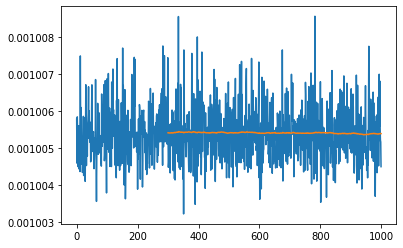

In [9]:
# validation
taus = []
for i in range(1000):
    x = np.random.randn(2,) / 16.
    a_agent, tau = a.forward(x)
    taus.append(tau)
    print(f'NN: {a_agent}, opt: {np.dot(K, x)}')
plt.plot(range(len(taus)), taus)
plt.plot(range(300, len(taus)), moving_average(taus, 300))
plt.show()

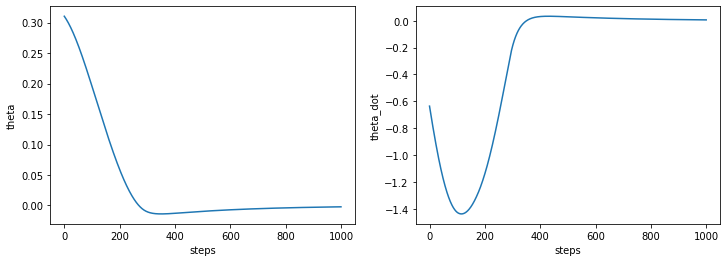

In [10]:
# 実環境テスト

def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2*np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
for i in range(1000):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()

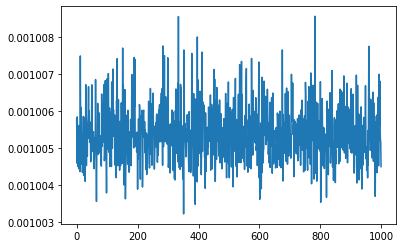

In [12]:
plt.plot(taus)